## Getting all node location information 

In [1]:
laser_power_profile_number = 1


In [2]:
import subprocess
import os

def download_with_progress(source_path, target_directory):
    # Define the path for the local download
    local_compressed_file_path = os.path.join(target_directory, os.path.basename(source_path))
    
    # Download the compressed file
    subprocess.run(['rclone', 'copy', source_path, target_directory], check=True)
    print(f"Downloaded {source_path} to {local_compressed_file_path}")

# Example usage
download_with_progress(f'Yi-Ping:/Exp_10_layer/compressed_laser_profile_{laser_power_profile_number}.zarr.zarr.tar.gz', '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing')


Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_1.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_1.zarr.zarr.tar.gz


In [3]:
import tarfile

def decompress_tar_gz(file_path, target_directory):
    # Check if the target directory exists, create if not
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    
    # Open the .tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all the contents into the target directory
        tar.extractall(path=target_directory)
        print(f"Decompressed {file_path} into {target_directory}")

# Example usage
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz"
target_directory = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing' # Change this to your actual target directory
decompress_tar_gz(file_path, target_directory)

Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_1.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


In [37]:
import zarr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, Rbf

# Assuming nodes_df is already defined and contains 'x', 'y', 'z' columns
# If not, you'll need to read the CSV file as before
filename = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/domain_nodes.csv'
nodes_df = pd.read_csv(filename)

# Add a 'node_number' column starting from 0
nodes_df['node_number'] = np.arange(len(nodes_df))

def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

# Paths to the Zarr arrays for x, y, and z coordinates
file_paths = {
    'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
    'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
    'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
}

# Convert each Zarr array to a DataFrame
dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

# Assuming the DataFrames are aligned and correspond to each other row-wise
# Combine the DataFrames into a single DataFrame with x, y, and z columns
tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
tool_path_df.columns = ['X', 'Y', 'Z']

toolpath_data = tool_path_df.iloc[:6295]

# Desired number of samples for interpolation
desired_samples = 6295

# Interpolating the toolpath data to reduce it to the desired number of samples
df_reduced_laser_location = pd.DataFrame({
    'X': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['X']),
    'Y': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Y']),
    'Z': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Z']),})


# Define the limits for x, y, and z
x_limits = (-20, 20)
y_limits = (-20, 20)
z_limits = (0, 8)

# Function to calculate distance to the nearest edge for each limit
def distance_to_nearest_edge(value, limits):
    return min(value - limits[0], limits[1] - value)

# Calculating the distances and adding them as new columns
df_reduced_laser_location['Dist_to_nearest_X'] = df_reduced_laser_location['X'].apply(distance_to_nearest_edge, args=(x_limits,))
df_reduced_laser_location['Dist_to_nearest_Y'] = df_reduced_laser_location['Y'].apply(distance_to_nearest_edge, args=(y_limits,))
df_reduced_laser_location['Dist_to_nearest_Z'] = 0


from tqdm import tqdm

# Load node locations (assuming this is already loaded as nodes_df with 'x', 'y', 'z', 'node_number')
# Load node temperature data from the Zarr file

solidus_temperature = 400
temp_file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/ff_dt_temperature"
zarr_temp_array = zarr.open(temp_file_path, mode='r')
temperature_data = np.array(zarr_temp_array).squeeze()  # Assuming it's a 2D array (time steps x nodes)
# Pre-define lists to accumulate data
time_steps = []
xs = []
ys = []
zs = []
temperatures = []

x_range = 1.5
y_range = 1.5
z_range = 4
half_x_range = x_range / 2
half_y_range = y_range / 2

melt_pool_depth_save = np.empty((len(toolpath_data),1))


for specific_time_step in tqdm(range(len(toolpath_data)), desc="Processing Time Steps"):
    specific_temperatures = temperature_data[specific_time_step, :]
    nodes_df['temperature'] = specific_temperatures

    # Filter nodes above solidus temperature and find the max z
    nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
    max_z = nodes_above_solidus['z'].max()

    # Filter for nodes with max_z
    for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
        time_steps.append(specific_time_step)
        xs.append(row['x'])
        ys.append(row['y'])
        zs.append(row['z'])
        temperatures.append(row['temperature'])
    
    # Filter nodes within the search box
    from scipy.interpolate import griddata, Rbf, RBFInterpolator
    laser_location_x = toolpath_data["X"][specific_time_step]
    laser_location_y = toolpath_data["Y"][specific_time_step]
    laser_location_z = toolpath_data["Z"][specific_time_step]
    
    
    in_cube_cond = (nodes_df["x"]<= float(laser_location_x) + x_range/2) & \
                    (nodes_df["x"]>= float(laser_location_x) - x_range/2) & \
                    (nodes_df["y"]<= float(laser_location_y) + y_range/2) & \
                    (nodes_df["y"]>= float(laser_location_y) - y_range/2) & \
                    (nodes_df["z"]>= float(laser_location_z) - z_range)
    
    nodes_melt_pool_range = nodes_df[in_cube_cond]
    
    # Check if we have any nodes in the melt pool range
    if not nodes_melt_pool_range.empty:
        try:
            points = nodes_melt_pool_range[['x', 'y', 'z']].values
            values = nodes_melt_pool_range['temperature'].values

            # # Define the grid for interpolation
            grid_x, grid_y, grid_z = np.mgrid[
                laser_location_x - half_x_range:laser_location_x + half_x_range:5j,
                laser_location_y - half_y_range:laser_location_y + half_y_range:5j,
                max(laser_location_z - z_range, nodes_melt_pool_range['z'].min()):laser_location_z:50j
            ]

            # # Perform interpolation using griddata
            # temp_interp = griddata(points, values, (grid_x, grid_y, grid_z), method='cubic')
            
            # using RBF            
            # rbf_cube = Rbf(nodes_melt_pool_range['x'], nodes_melt_pool_range['y'], nodes_melt_pool_range['z'],nodes_melt_pool_range['temperature'])
            # temp_interp = rbf_cube(grid_x, grid_y, grid_z)
            
            # using RBFInterpolator
            rbf_cube = RBFInterpolator(points, values)
            points_3D = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
            temp_interp = rbf_cube(points_3D)
            temp_interp = temp_interp.reshape(grid_x.shape)
            
            
            # # Process interpolated temperature data
            mask_above_solidus = temp_interp >= 1600
            mp_z = grid_z[mask_above_solidus]
            melt_pool_depth = np.max(mp_z) - np.min(mp_z) - 0.75
        except:
            melt_pool_depth = 0
    else: 
        melt_pool_depth = 0
    
    melt_pool_depth_save[specific_time_step] = melt_pool_depth
    

Processing Time Steps: 100%|██████████| 6295/6295 [13:39<00:00,  7.68it/s]


In [29]:
mp_z = grid_z[mask_above_solidus]
mp_z

array([], dtype=float64)

In [7]:
def collect_melt_pool_depth():
    # Filter nodes within the search box
    from scipy.interpolate import griddata
    laser_location_x = toolpath_data["X"][specific_time_step]
    laser_location_y = toolpath_data["Y"][specific_time_step]
    laser_location_z = toolpath_data["Z"][specific_time_step]
    
    
    in_cube_cond = (nodes_df["x"]<= float(laser_location_x) + x_range/2) & \
                    (nodes_df["x"]>= float(laser_location_x) - x_range/2) & \
                    (nodes_df["y"]<= float(laser_location_y) + y_range/2) & \
                    (nodes_df["y"]>= float(laser_location_y) - y_range/2) & \
                    (nodes_df["z"]>= float(laser_location_z) - z_range)
    
    nodes_melt_pool_range = nodes_df[in_cube_cond]
    
    # Check if we have any nodes in the melt pool range
    if not nodes_melt_pool_range.empty:
        try:
            points = nodes_melt_pool_range[['x', 'y', 'z']].values
            values = nodes_melt_pool_range['temperature'].values

            # Define the grid for interpolation
            grid_x, grid_y, grid_z = np.mgrid[
                laser_location_x - half_x_range:laser_location_x + half_x_range:30j,
                laser_location_y - half_y_range:laser_location_y + half_y_range:20j,
                max(laser_location_z - z_range, nodes_melt_pool_range['z'].min()):laser_location_z:40j
            ]

            # Perform interpolation using griddata
            temp_interp = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

            # Process interpolated temperature data
            mask_above_solidus = temp_interp >= 1600
            mp_z = grid_z[mask_above_solidus]

            
            melt_pool_depth = np.max(mp_z) - np.min(mp_z) - 0.75
        except:
            melt_pool_depth = 0
    else: 
        melt_pool_depth = 0
    
    melt_pool_depth_save[specific_time_step] = melt_pool_depth

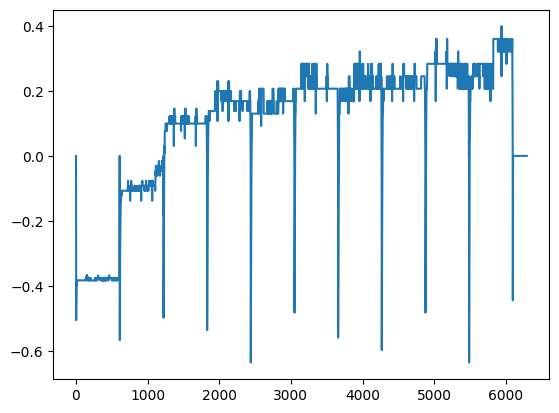

In [36]:
import matplotlib.pyplot as plt
def moving_average_1d(data, window_size):
    if window_size < 1:
        raise ValueError("Window size must be at least 1")
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='valid')

depth_mva = moving_average_1d(melt_pool_depth_save[:,0],2)

plt.plot(depth_mva)

In [15]:
import zarr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, Rbf

# Assuming nodes_df is already defined and contains 'x', 'y', 'z' columns
# If not, you'll need to read the CSV file as before
filename = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/domain_nodes.csv'
nodes_df = pd.read_csv(filename)

# Add a 'node_number' column starting from 0
nodes_df['node_number'] = np.arange(len(nodes_df))

def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

# Paths to the Zarr arrays for x, y, and z coordinates
file_paths = {
    'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
    'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
    'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
}

# Convert each Zarr array to a DataFrame
dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

# Assuming the DataFrames are aligned and correspond to each other row-wise
# Combine the DataFrames into a single DataFrame with x, y, and z columns
tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
tool_path_df.columns = ['X', 'Y', 'Z']

toolpath_data = tool_path_df.iloc[:6295]

# Desired number of samples for interpolation
desired_samples = 6295

# Interpolating the toolpath data to reduce it to the desired number of samples
df_reduced_laser_location = pd.DataFrame({
    'X': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['X']),
    'Y': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Y']),
    'Z': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Z']),})


# Define the limits for x, y, and z
x_limits = (-20, 20)
y_limits = (-20, 20)
z_limits = (0, 8)

# Function to calculate distance to the nearest edge for each limit
def distance_to_nearest_edge(value, limits):
    return min(value - limits[0], limits[1] - value)

# Calculating the distances and adding them as new columns
df_reduced_laser_location['Dist_to_nearest_X'] = df_reduced_laser_location['X'].apply(distance_to_nearest_edge, args=(x_limits,))
df_reduced_laser_location['Dist_to_nearest_Y'] = df_reduced_laser_location['Y'].apply(distance_to_nearest_edge, args=(y_limits,))
df_reduced_laser_location['Dist_to_nearest_Z'] = 0


from tqdm import tqdm

# Load node locations (assuming this is already loaded as nodes_df with 'x', 'y', 'z', 'node_number')
# Load node temperature data from the Zarr file

solidus_temperature = 400
temp_file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/ff_dt_temperature"
zarr_temp_array = zarr.open(temp_file_path, mode='r')
temperature_data = np.array(zarr_temp_array).squeeze()  # Assuming it's a 2D array (time steps x nodes)
# Pre-define lists to accumulate data
time_steps = []
xs = []
ys = []
zs = []
temperatures = []


for specific_time_step in tqdm(range(len(temperature_data)), desc="Processing Time Steps"):
    specific_temperatures = temperature_data[specific_time_step, :]
    nodes_df['temperature'] = specific_temperatures

    # Filter nodes above solidus temperature and find the max z
    nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
    max_z = nodes_above_solidus['z'].max()

    # Filter for nodes with max_z
    for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
        time_steps.append(specific_time_step)
        xs.append(row['x'])
        ys.append(row['y'])
        zs.append(row['z'])
        temperatures.append(row['temperature'])
        
    
    

# Load the time index from the Zarr file
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/timestamp"
zarr_array = zarr.open(file_path, mode='r')
time_index_array = np.array(zarr_array).squeeze()[:6295]  # Assuming it's a 1D array

# Convert lists to DataFrame
all_nodes_with_max_z = pd.DataFrame({
    'time_step': time_steps,
    'x': xs,
    'y': ys,
    'z': zs,
    'temperature': temperatures
})

import zarr
import pandas as pd
import numpy as np

def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

# Paths to the Zarr arrays for x, y, and z coordinates
file_paths = {
    'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
    'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
    'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
}

# Convert each Zarr array to a DataFrame
dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

# Assuming the DataFrames are aligned and correspond to each other row-wise
# Combine the DataFrames into a single DataFrame with x, y, and z columns
tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
tool_path_df.columns = ['x', 'y', 'z']
#tool_path_df = tool_path_df.iloc[1:]
# Now `tool_path_df` contains the combined tool path with x, y, and z coordinates


# Calculating the difference (delta) for each axis to determine direction change
tool_path_df['dx'] = tool_path_df['x'].diff()
tool_path_df['dy'] = tool_path_df['y'].diff()
tool_path_df['dz'] = tool_path_df['z'].diff()

# Since calculating direction at each second requires time data which is not provided,
# We'll just calculate the direction change between each recorded point.
# Note: For accurate per-second analysis, time data would be necessary.

# Simply indicating direction change without normalization for simplicity
direction_changes = tool_path_df[['dx', 'dy', 'dz']].fillna(0)

direction_changes


direction_changes_df = pd.DataFrame(direction_changes)


# Calculate the magnitude of each vector
magnitude = (direction_changes_df['dx']**2 + direction_changes_df['dy']**2 + direction_changes_df['dz']**2)**0.5

# Avoid division by zero by setting zero magnitudes to 1 (effectively making the direction vector [0,0,0] for no movement)
magnitude[magnitude == 0] = 1

# Calculate unit vector components
direction_changes_df['unit_dx'] = direction_changes_df['dx'] / magnitude
direction_changes_df['unit_dy'] = direction_changes_df['dy'] / magnitude
direction_changes_df['unit_dz'] = direction_changes_df['dz'] / magnitude

direction_changes_df[['unit_dx', 'unit_dy', 'unit_dz']]


import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Assuming all_nodes_with_max_z and direction_changes_df are pre-loaded

solidus_temp = 1648.15
liquidus_temp = 1673.15

def fit_temperature_surface(time_step):
    specific_data = all_nodes_with_max_z[all_nodes_with_max_z['time_step'] == time_step]
    if specific_data.empty:
        print(f"No data available for time step {time_step}.")
        return np.nan, np.nan, np.nan
    laser_center = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
    bounding_box = {'xmin': laser_center['x'] - 3, 'xmax': laser_center['x'] + 3,
                    'ymin': laser_center['y'] - 3, 'ymax': laser_center['y'] + 3}
    bounded_data = specific_data[
        (specific_data['x'] >= bounding_box['xmin']) & (specific_data['x'] <= bounding_box['xmax']) &
        (specific_data['y'] >= bounding_box['ymin']) & (specific_data['y'] <= bounding_box['ymax']) &
        (specific_data['temperature'] <= 20000)
    ]
    if bounded_data.shape[0] < 5:
        print(f"Not enough data points for interpolation at time step {time_step}.")
        return [np.nan], np.nan, np.nan, np.nan
    # Prepare points and values for griddata interpolation
    points = bounded_data[['x', 'y']].values
    values = bounded_data['temperature'].values

    return points, values, bounding_box, specific_data

def calculate_melt_pool_temperature(points, values, center_x, center_y, radius=0.45):
    # theta = np.linspace(0, 2 * np.pi, 100)
    # x = center_x + radius * np.cos(theta)
    # y = center_y + radius * np.sin(theta)
    # # Use griddata for interpolation over a circle around the laser center
    # z = griddata(points, values, (x, y), method='linear')
    # return np.nanmean(z)  # Use nanmean to safely handle NaNs

    RBF_surf = Rbf(points[:,0],points[:,1],values, function='linear')
    x_range = np.linspace(center_x-radius,center_x+radius,30)
    y_range = np.linspace(center_y-radius,center_y+radius,30)
    X,Y = np.meshgrid(x_range,y_range)
    Z = RBF_surf(X,Y)
    Xr = X.ravel()
    Yr = Y.ravel()
    in_circle = np.sqrt((Xr-center_x)**2+(Yr-center_y)**2)
    mask = np.where(in_circle<=(radius))
    Zr = Z.ravel()
    Z_in_circle = Zr[mask]
    return np.mean(Z_in_circle)
    

def collect_melt_pool_temperatures():
    temperatures = []
    time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
    for time_step in tqdm(time_steps):  
        points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
        # Check if points is None or empty
        if len(points) < 5:
        # if points is None or len(points) == 0:
            print(f"No data available for time step {time_step}.")
            temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
            continue
        else:
            tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
            melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
            temperatures.append(melt_pool_temp)
    return np.array(temperatures)

# Collecting melt pool temperatures for all time steps
melt_pool_temperatures = collect_melt_pool_temperatures()


# Read the data from the file 'toolpath.crs'
file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/toolpath.crs'
df_toolpath_crs = pd.read_csv(file_path, sep='\t', header=None, names=['Time', 'X', 'Y', 'Z', 'Laser State'])

# Interpolating and extrapolating functions for time and scanning speed
def interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps):
    valid_points = df_toolpath_crs[df_toolpath_crs['Laser State'] == 1]
    
    # Interpolation functions for X, Y, Z coordinates
    interp_func_x = interp1d(valid_points['Time'], valid_points['X'], fill_value="extrapolate")
    interp_func_y = interp1d(valid_points['Time'], valid_points['Y'], fill_value="extrapolate")
    interp_func_z = interp1d(valid_points['Time'], valid_points['Z'], fill_value="extrapolate")
    
    # Interpolated coordinates for new time steps
    interpolated_x = interp_func_x(new_time_steps)
    interpolated_y = interp_func_y(new_time_steps)
    interpolated_z = interp_func_z(new_time_steps)
    
    return pd.DataFrame({
        'Time': new_time_steps,
        'X': interpolated_x,
        'Y': interpolated_y,
        'Z': interpolated_z
    })

# Define the file path to the Zarr array that contains the laser power data
file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_laser_power"

# Open the Zarr array directly (ensure this is the correct path to the array)
zarr_array = zarr.open(file_path, mode='r')

# Initialize a DataFrame from the Zarr array if it is 2D
if zarr_array.ndim == 2:
    # Convert the Zarr array to a NumPy array
    numpy_array = np.array(zarr_array)
    
    # Convert the NumPy array to a DataFrame and rename columns for clarity
    laser_power_df = pd.DataFrame(numpy_array)
else:
    print("The Zarr array is not 2D. Additional processing may be required.")

laser_power_df = laser_power_df[1:6296]*2.5

# Calculate scanning speed for interpolated/extrapolated time steps
def calculate_scanning_speeds(df_interpolated):
    scanning_speeds = []

    for i in range(1, len(df_interpolated)):
        time1 = df_interpolated.loc[i-1, 'Time']
        time2 = df_interpolated.loc[i, 'Time']
        x1, y1, z1 = df_interpolated.loc[i-1, ['X', 'Y', 'Z']]
        x2, y2, z2 = df_interpolated.loc[i, ['X', 'Y', 'Z']]
        
        # Calculate Euclidean distance
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        
        # Calculate time difference
        time_diff = time2 - time1
        
        # Calculate scanning speed
        if time_diff > 0:
            scanning_speed = distance / time_diff
            scanning_speeds.append({
                'time_step': time2,
                'scanning_speed': scanning_speed
            })

    return pd.DataFrame(scanning_speeds)

# Define new time steps for interpolation/extrapolation
new_time_steps = np.linspace(0, 225, 6296)

# Interpolate and extrapolate the data for the new time steps
df_interpolated = interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps)

# Calculate scanning speeds for the interpolated/extrapolated time steps
scanning_speeds_df = calculate_scanning_speeds(df_interpolated)['scanning_speed']




100%|██████████| 6295/6295 [00:32<00:00, 193.22it/s]


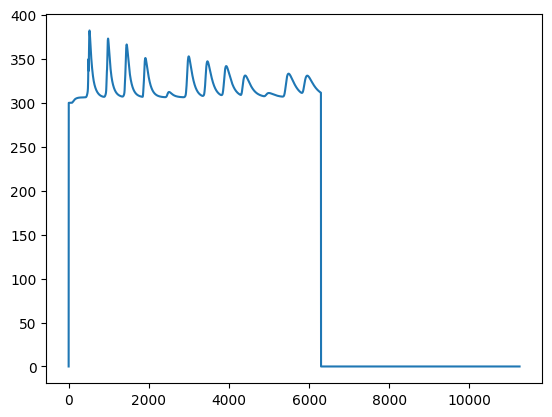

In [20]:
for specific_time_step in tqdm(range(len(temperature_data)), desc="Processing Time Steps"):
    specific_temperatures = temperature_data[specific_time_step, :]
    nodes_df['temperature'] = specific_temperatures

    # Filter nodes above solidus temperature and find the max z
    nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
    max_z = nodes_above_solidus['z'].max()

    # Filter for nodes with max_z
    for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
        time_steps.append(specific_time_step)
        xs.append(row['x'])
        ys.append(row['y'])
        zs.append(row['z'])
        temperatures.append(row['temperature'])


def collect_melt_pool_depth():
    # Filter nodes within the search box
    from scipy.interpolate import griddata
    x_range = 1.5
    y_range = 1.5
    z_range = 3
    half_x_range = x_range / 2
    half_y_range = y_range / 2

    melt_pool_depth_save = np.empty((len(temperature_data),1))
    
    time_steps = 6296
    for specific_time_step in tqdm(range(time_steps)):
        laser_location_x = df_interpolated["X"][specific_time_step]
        laser_location_y = df_interpolated["Y"][specific_time_step]
        laser_location_z = df_interpolated["Z"][specific_time_step]
        
        
        in_cube_cond = (nodes_df["x"]<= float(laser_location_x) + x_range/2) & \
                        (nodes_df["x"]>= float(laser_location_x) - x_range/2) & \
                        (nodes_df["y"]<= float(laser_location_y) + y_range/2) & \
                        (nodes_df["y"]>= float(laser_location_y) - y_range/2) & \
                        (nodes_df["z"]>= float(laser_location_z) - z_range)
        
        nodes_melt_pool_range = nodes_df[in_cube_cond]
        
        # Check if we have any nodes in the melt pool range
        if not nodes_melt_pool_range.empty:
            try:
                points = nodes_melt_pool_range[['x', 'y', 'z']].values
                values = nodes_melt_pool_range['temperature'].values

                # Define the grid for interpolation
                grid_x, grid_y, grid_z = np.mgrid[
                    laser_location_x - half_x_range:laser_location_x + half_x_range:30j,
                    laser_location_y - half_y_range:laser_location_y + half_y_range:20j,
                    max(laser_location_z - z_range, nodes_melt_pool_range['z'].min()):laser_location_z:40j
                ]

                # Perform interpolation using griddata
                temp_interp = griddata(points, values, (grid_x, grid_y, grid_z), method='cubic')

                # Process interpolated temperature data
                mask_above_solidus = temp_interp >= 1600
                mp_z = grid_z[mask_above_solidus]

                
                melt_pool_depth = np.max(mp_z) - np.min(mp_z) - 0.75
            except:
                melt_pool_depth = 0
        else: 
            melt_pool_depth = 0
        
        melt_pool_depth_save[specific_time_step] = melt_pool_depth
    return melt_pool_depth_save

In [41]:
df_reduced_laser_location

,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z
0,0.000000,0.000000,0.00,20.000000,20.000000,0
1,-17.000000,19.250000,0.75,3.000000,0.750000,0
2,-17.000000,19.250000,0.75,3.000000,0.750000,0
3,-16.999445,19.250000,0.75,3.000555,0.750000,0
4,-16.749265,19.250000,0.75,3.250735,0.750000,0
...,...,...,...,...,...,...
6290,17.063101,-18.170275,7.50,2.936899,1.829725,0
6291,17.051954,-18.361006,7.50,2.948046,1.638994,0
6292,17.040808,-18.551738,7.50,2.959192,1.448262,0
6293,17.029661,-18.742469,7.50,2.970339,1.257531,0


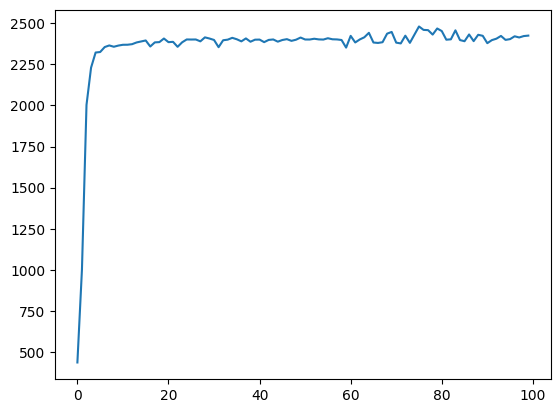

In [13]:
plt.plot(melt_pool_temperatures[:200][::2])

In [ ]:
time_index_df = pd.DataFrame({'time_index': time_index_array})
melt_pool_temperatures_df = pd.DataFrame({'melt_pool_temperature': melt_pool_temperatures[:-1]})
melt_pool_depth_df = pd.DataFrame({'melt_pool_depth': melt_pool_depth[:,-1]})
scanning_speeds_df = pd.DataFrame({'scanning_speed': scanning_speeds_df.to_numpy()})
X_df = pd.DataFrame({'X': df_reduced_laser_location['X'].to_numpy()})
Y_df = pd.DataFrame({'Y': df_reduced_laser_location['Y'].to_numpy()})
Z_df = pd.DataFrame({'Z': df_reduced_laser_location['Z'].to_numpy()})
Dist_to_nearest_X_df = pd.DataFrame({'Dist_to_nearest_X': df_reduced_laser_location['Dist_to_nearest_X'].to_numpy()})
Dist_to_nearest_Y_df = pd.DataFrame({'Dist_to_nearest_Y': df_reduced_laser_location['Dist_to_nearest_Y'].to_numpy()})
Dist_to_nearest_Z_df = pd.DataFrame({'Dist_to_nearest_Z': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
laser_power_number_df = pd.DataFrame({'laser_power_number': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
laser_power_number_df['laser_power_number']=laser_power_profile_number
laser_power_df.columns = ["Laser_power"]
laser_power_df.reset_index(drop=True, inplace=True)

In [ ]:
# Merging all DataFrames into one
merged_df = pd.concat([
    time_index_df, 
    melt_pool_temperatures_df, 
    melt_pool_depth_df,
    scanning_speeds_df, 
    X_df, 
    Y_df, 
    Z_df, 
    Dist_to_nearest_X_df, 
    Dist_to_nearest_Y_df, 
    Dist_to_nearest_Z_df, 
    laser_power_df,
    laser_power_number_df
], axis=1)

In [ ]:
import shutil

os.remove(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz")
shutil.rmtree(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr")


In [4]:
csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/single_laser_profile.csv'
merged_df.to_csv(csv_file_path, index=False)

NameError: name 'merged_df' is not defined

# Complete For Loop

In [41]:

import subprocess
import os
import tarfile
import zarr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, Rbf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import copy

### Functions

In [42]:
def download_with_progress(source_path, target_directory):
    # Define the path for the local download
    local_compressed_file_path = os.path.join(target_directory, os.path.basename(source_path))
    
    # Download the compressed file
    subprocess.run(['rclone', 'copy', source_path, target_directory], check=True)
    print(f"Downloaded {source_path} to {local_compressed_file_path}")
    
    

def decompress_tar_gz(file_path, target_directory):
    # Check if the target directory exists, create if not
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    
    # Open the .tar.gz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Extract all the contents into the target directory
        tar.extractall(path=target_directory)
        print(f"Decompressed {file_path} into {target_directory}")
        
def zarr_to_df(file_path):
    # Open the Zarr array directly
    zarr_array = zarr.open(file_path, mode='r')
    
    # Ensure the Zarr array is 2D
    if zarr_array.ndim != 2:
        raise ValueError("The Zarr array is not 2D. Additional processing may be required.")
    
    # Convert the Zarr array to a NumPy array then to a DataFrame
    numpy_array = np.array(zarr_array)
    df = pd.DataFrame(numpy_array)
    return df

def fit_temperature_surface(time_step):
    specific_data = all_nodes_with_max_z[all_nodes_with_max_z['time_step'] == time_step]
    if specific_data.empty:
        print(f"No data available for time step {time_step}.")
        return np.nan, np.nan, np.nan
    laser_center = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
    bounding_box = {'xmin': laser_center['x'] - 3, 'xmax': laser_center['x'] + 3,
                    'ymin': laser_center['y'] - 3, 'ymax': laser_center['y'] + 3}
    bounded_data = specific_data[
        (specific_data['x'] >= bounding_box['xmin']) & (specific_data['x'] <= bounding_box['xmax']) &
        (specific_data['y'] >= bounding_box['ymin']) & (specific_data['y'] <= bounding_box['ymax']) &
        (specific_data['temperature'] <= 20000)
    ]
    if bounded_data.shape[0] < 5:
        print(f"Not enough data points for interpolation at time step {time_step}.")
        return [np.nan], np.nan, np.nan, np.nan
    # Prepare points and values for griddata interpolation
    points = bounded_data[['x', 'y']].values
    values = bounded_data['temperature'].values

    return points, values, bounding_box, specific_data

def calculate_melt_pool_temperature(points, values, center_x, center_y, radius=0.45):
    # theta = np.linspace(0, 2 * np.pi, 100)
    # x = center_x + radius * np.cos(theta)
    # y = center_y + radius * np.sin(theta)
    # # Use griddata for interpolation over a circle around the laser center
    # z = griddata(points, values, (x, y), method='linear')
    # return np.nanmean(z)  # Use nanmean to safely handle NaNs

    RBF_surf = Rbf(points[:,0],points[:,1],values, function='linear')
    x_range = np.linspace(center_x-radius,center_x+radius,30)
    y_range = np.linspace(center_y-radius,center_y+radius,30)
    X,Y = np.meshgrid(x_range,y_range)
    Z = RBF_surf(X,Y)
    Xr = X.ravel()
    Yr = Y.ravel()
    in_circle = np.sqrt((Xr-center_x)**2+(Yr-center_y)**2)
    mask = np.where(in_circle<=(radius))
    Zr = Z.ravel()
    Z_in_circle = Zr[mask]
    return np.mean(Z_in_circle)

# def collect_melt_pool_temperatures():
#     temperatures = []
#     time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
#     for time_step in tqdm(time_steps[::2]):  
#         points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
#         # Check if points is None or empty
#         if points is None or len(points) == 0:
#             print(f"No data available for time step {time_step}.")
#             temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
#             continue
#         tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
#         melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
#         temperatures.append(melt_pool_temp)
#         temperatures.append(melt_pool_temp)    
#     return np.array(temperatures)

def collect_melt_pool_temperatures():
    temperatures = []
    time_steps = np.sort(all_nodes_with_max_z['time_step'].unique())
    for time_step in tqdm(time_steps):  
        points, values, bounding_box, specific_data = fit_temperature_surface(time_step)
        # Check if points is None or empty
        if len(points) < 5:
        # if points is None or len(points) == 0:
            print(f"No data available for time step {time_step}.")
            temperatures.append(np.nan)  # Append NaN if interpolation data isn't available
            continue
        else:
            tool_position = specific_data.loc[specific_data['temperature'].idxmax(), ['x', 'y']]
            melt_pool_temp = calculate_melt_pool_temperature(points, values, tool_position['x'], tool_position['y'])
            temperatures.append(melt_pool_temp)
    return np.array(temperatures)

# Interpolating and extrapolating functions for time and scanning speed
def interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps):
    valid_points = df_toolpath_crs[df_toolpath_crs['Laser State'] == 1]
    
    # Interpolation functions for X, Y, Z coordinates
    interp_func_x = interp1d(valid_points['Time'], valid_points['X'], fill_value="extrapolate")
    interp_func_y = interp1d(valid_points['Time'], valid_points['Y'], fill_value="extrapolate")
    interp_func_z = interp1d(valid_points['Time'], valid_points['Z'], fill_value="extrapolate")
    
    # Interpolated coordinates for new time steps
    interpolated_x = interp_func_x(new_time_steps)
    interpolated_y = interp_func_y(new_time_steps)
    interpolated_z = interp_func_z(new_time_steps)
    
    return pd.DataFrame({
        'Time': new_time_steps,
        'X': interpolated_x,
        'Y': interpolated_y,
        'Z': interpolated_z
    })
    
# Calculate scanning speed for interpolated/extrapolated time steps
def calculate_scanning_speeds(df_interpolated):
    scanning_speeds = []

    for i in range(1, len(df_interpolated)):
        time1 = df_interpolated.loc[i-1, 'Time']
        time2 = df_interpolated.loc[i, 'Time']
        x1, y1, z1 = df_interpolated.loc[i-1, ['X', 'Y', 'Z']]
        x2, y2, z2 = df_interpolated.loc[i, ['X', 'Y', 'Z']]
        
        # Calculate Euclidean distance
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        
        # Calculate time difference
        time_diff = time2 - time1
        
        # Calculate scanning speed
        if time_diff > 0:
            scanning_speed = distance / time_diff
            scanning_speeds.append({
                'time_step': time2,
                'scanning_speed': scanning_speed
            })

    return pd.DataFrame(scanning_speeds)



In [55]:
laser_power_profile_number = 1
for laser_number in range(99):

# laser_power_profile_number = 0
# for laser_number in range(1):
    laser_power_profile_number += 1
    if laser_power_profile_number == 80:
        laser_power_profile_number = 81
    
    # download
    download_with_progress(f'Yi-Ping:/Exp_10_layer/compressed_laser_profile_{laser_power_profile_number}.zarr.zarr.tar.gz', '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing')
    # decompress
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz"
    target_directory = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing' # Change this to your actual target directory
    decompress_tar_gz(file_path, target_directory)
    
    # Assuming nodes_df is already defined and contains 'x', 'y', 'z' columns
    # If not, you'll need to read the CSV file as before
    filename = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/domain_nodes.csv'
    nodes_df = pd.read_csv(filename)

    # Add a 'node_number' column starting from 0
    nodes_df['node_number'] = np.arange(len(nodes_df))
    
    # Paths to the Zarr arrays for x, y, and z coordinates
    file_paths = {
        'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
        'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
        'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
    }

    # Convert each Zarr array to a DataFrame
    dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

    # Assuming the DataFrames are aligned and correspond to each other row-wise
    # Combine the DataFrames into a single DataFrame with x, y, and z columns
    tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
    tool_path_df.columns = ['X', 'Y', 'Z']

    toolpath_data = tool_path_df.iloc[:6295]

    # Desired number of samples for interpolation
    desired_samples = 6295

    # Interpolating the toolpath data to reduce it to the desired number of samples
    df_reduced_laser_location = pd.DataFrame({
        'X': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['X']),
        'Y': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Y']),
        'Z': np.interp(np.linspace(0, len(toolpath_data)-1, desired_samples), np.arange(len(toolpath_data)), toolpath_data['Z']),})


    # Define the limits for x, y, and z
    x_limits = (-20, 20)
    y_limits = (-20, 20)
    z_limits = (0, 8)

    # Function to calculate distance to the nearest edge for each limit
    def distance_to_nearest_edge(value, limits):
        return min(value - limits[0], limits[1] - value)

    # Calculating the distances and adding them as new columns
    df_reduced_laser_location['Dist_to_nearest_X'] = df_reduced_laser_location['X'].apply(distance_to_nearest_edge, args=(x_limits,))
    df_reduced_laser_location['Dist_to_nearest_Y'] = df_reduced_laser_location['Y'].apply(distance_to_nearest_edge, args=(y_limits,))
    df_reduced_laser_location['Dist_to_nearest_Z'] = 0


    from tqdm import tqdm

    # Load node locations (assuming this is already loaded as nodes_df with 'x', 'y', 'z', 'node_number')
    # Load node temperature data from the Zarr file

    solidus_temperature = 400
    temp_file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/ff_dt_temperature"
    zarr_temp_array = zarr.open(temp_file_path, mode='r')
    temperature_data = np.array(zarr_temp_array).squeeze()  # Assuming it's a 2D array (time steps x nodes)
    # Pre-define lists to accumulate data
    time_steps = []
    xs = []
    ys = []
    zs = []
    temperatures = []
    
    x_range = 1.5
    y_range = 1.5
    z_range = 4
    half_x_range = x_range / 2
    half_y_range = y_range / 2

    melt_pool_depth_save = np.empty((len(toolpath_data),1))

    for specific_time_step in tqdm(range(len(toolpath_data)), desc="Processing Time Steps"):
        specific_temperatures = temperature_data[specific_time_step, :]
        nodes_df['temperature'] = specific_temperatures

        # Filter nodes above solidus temperature and find the max z
        nodes_above_solidus = nodes_df[nodes_df['temperature'] > solidus_temperature]
        max_z = nodes_above_solidus['z'].max()

        # Filter for nodes with max_z
        for _, row in nodes_above_solidus[nodes_above_solidus['z'] == max_z].iterrows():
            time_steps.append(specific_time_step)
            xs.append(row['x'])
            ys.append(row['y'])
            zs.append(row['z'])
            temperatures.append(row['temperature'])
    # Filter nodes within the search box
        from scipy.interpolate import griddata, Rbf, RBFInterpolator
        laser_location_x = toolpath_data["X"][specific_time_step]
        laser_location_y = toolpath_data["Y"][specific_time_step]
        laser_location_z = toolpath_data["Z"][specific_time_step]
        
        
        in_cube_cond = (nodes_df["x"]<= float(laser_location_x) + x_range/2) & \
                        (nodes_df["x"]>= float(laser_location_x) - x_range/2) & \
                        (nodes_df["y"]<= float(laser_location_y) + y_range/2) & \
                        (nodes_df["y"]>= float(laser_location_y) - y_range/2) & \
                        (nodes_df["z"]>= float(laser_location_z) - z_range)
        
        nodes_melt_pool_range = nodes_df[in_cube_cond]
        
        # Check if we have any nodes in the melt pool range
        if not nodes_melt_pool_range.empty:
            try:
                points = nodes_melt_pool_range[['x', 'y', 'z']].values
                values = nodes_melt_pool_range['temperature'].values

                # # Define the grid for interpolation
                grid_x, grid_y, grid_z = np.mgrid[
                    laser_location_x - half_x_range:laser_location_x + half_x_range:5j,
                    laser_location_y - half_y_range:laser_location_y + half_y_range:5j,
                    max(laser_location_z - z_range, nodes_melt_pool_range['z'].min()):laser_location_z:50j
                ]

                # # Perform interpolation using griddata
                # temp_interp = griddata(points, values, (grid_x, grid_y, grid_z), method='cubic')
                
                # using RBF            
                # rbf_cube = Rbf(nodes_melt_pool_range['x'], nodes_melt_pool_range['y'], nodes_melt_pool_range['z'],nodes_melt_pool_range['temperature'])
                # temp_interp = rbf_cube(grid_x, grid_y, grid_z)
                
                # using RBFInterpolator
                rbf_cube = RBFInterpolator(points, values)
                points_3D = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()]).T
                temp_interp = rbf_cube(points_3D)
                temp_interp = temp_interp.reshape(grid_x.shape)
                
                
                # # Process interpolated temperature data
                mask_above_solidus = temp_interp >= 1600
                mp_z = grid_z[mask_above_solidus]
                melt_pool_depth = np.max(mp_z) - np.min(mp_z) - 0.75
            except:
                melt_pool_depth = 0
        else: 
            melt_pool_depth = 0
        
        melt_pool_depth_save[specific_time_step] = melt_pool_depth
        
    # Load the time index from the Zarr file
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/timestamp"
    zarr_array = zarr.open(file_path, mode='r')
    time_index_array = np.array(zarr_array).squeeze()[:6295]  # Assuming it's a 1D array

    # Convert lists to DataFrame
    all_nodes_with_max_z = pd.DataFrame({
        'time_step': time_steps,
        'x': xs,
        'y': ys,
        'z': zs,
        'temperature': temperatures
    })


        # Paths to the Zarr arrays for x, y, and z coordinates
    file_paths = {
        'x': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_x",
        'y': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_y",
        'z': f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_pos_z"
    }

    # Convert each Zarr array to a DataFrame
    dfs = {coord: zarr_to_df(path) for coord, path in file_paths.items()}

    # Assuming the DataFrames are aligned and correspond to each other row-wise
    # Combine the DataFrames into a single DataFrame with x, y, and z columns
    tool_path_df = pd.concat([dfs['x'], dfs['y'], dfs['z']], axis=1)
    tool_path_df.columns = ['x', 'y', 'z']
    #tool_path_df = tool_path_df.iloc[1:]
    # Now `tool_path_df` contains the combined tool path with x, y, and z coordinates


    # Calculating the difference (delta) for each axis to determine direction change
    tool_path_df['dx'] = tool_path_df['x'].diff()
    tool_path_df['dy'] = tool_path_df['y'].diff()
    tool_path_df['dz'] = tool_path_df['z'].diff()

    # Since calculating direction at each second requires time data which is not provided,
    # We'll just calculate the direction change between each recorded point.
    # Note: For accurate per-second analysis, time data would be necessary.

    # Simply indicating direction change without normalization for simplicity
    direction_changes = tool_path_df[['dx', 'dy', 'dz']].fillna(0)

    direction_changes


    direction_changes_df = pd.DataFrame(direction_changes)

    # Calculate the magnitude of each vector
    magnitude = (direction_changes_df['dx']**2 + direction_changes_df['dy']**2 + direction_changes_df['dz']**2)**0.5

    # Avoid division by zero by setting zero magnitudes to 1 (effectively making the direction vector [0,0,0] for no movement)
    magnitude[magnitude == 0] = 1

    # Calculate unit vector components
    direction_changes_df['unit_dx'] = direction_changes_df['dx'] / magnitude
    direction_changes_df['unit_dy'] = direction_changes_df['dy'] / magnitude
    direction_changes_df['unit_dz'] = direction_changes_df['dz'] / magnitude

    direction_changes_df[['unit_dx', 'unit_dy', 'unit_dz']]
    
    # Assuming all_nodes_with_max_z and direction_changes_df are pre-loaded

    solidus_temp = 1648.15
    liquidus_temp = 1673.15
    
    # Collecting melt pool temperatures for all time steps
    melt_pool_temperatures = collect_melt_pool_temperatures()
    print("Melt Pool Temperatures for All Time Steps:", melt_pool_temperatures)

    # Read the data from the file 'toolpath.crs'
    file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/toolpath.crs'
    df_toolpath_crs = pd.read_csv(file_path, sep='\t', header=None, names=['Time', 'X', 'Y', 'Z', 'Laser State'])


    # Define the file path to the Zarr array that contains the laser power data
    file_path = f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr/dt_laser_power"

    # Open the Zarr array directly (ensure this is the correct path to the array)
    zarr_array = zarr.open(file_path, mode='r')

    # Initialize a DataFrame from the Zarr array if it is 2D
    if zarr_array.ndim == 2:
        # Convert the Zarr array to a NumPy array
        numpy_array = np.array(zarr_array)
        
        # Convert the NumPy array to a DataFrame and rename columns for clarity
        laser_power_df = pd.DataFrame(numpy_array)
    else:
        print("The Zarr array is not 2D. Additional processing may be required.")

    laser_power_df = laser_power_df[1:6296]*2.5
    
    # Define new time steps for interpolation/extrapolation
    new_time_steps = np.linspace(0, 225, 6296)

    # Interpolate and extrapolate the data for the new time steps
    df_interpolated = interpolate_extrapolate_time_steps(df_toolpath_crs, new_time_steps)

    # Calculate scanning speeds for the interpolated/extrapolated time steps
    scanning_speeds_df = calculate_scanning_speeds(df_interpolated)['scanning_speed']
    
    
    time_index_df = pd.DataFrame({'time_index': time_index_array})
    melt_pool_temperatures_df = pd.DataFrame({'melt_pool_temperature': melt_pool_temperatures[:-1]})
    melt_pool_depth_df = pd.DataFrame({'melt_pool_depth':melt_pool_depth_save[:-1,-1].squeeze()})
    scanning_speeds_df = pd.DataFrame({'scanning_speed': scanning_speeds_df.to_numpy()})
    X_df = pd.DataFrame({'X': df_reduced_laser_location['X'].to_numpy()})
    Y_df = pd.DataFrame({'Y': df_reduced_laser_location['Y'].to_numpy()})
    Z_df = pd.DataFrame({'Z': df_reduced_laser_location['Z'].to_numpy()})
    Dist_to_nearest_X_df = pd.DataFrame({'Dist_to_nearest_X': df_reduced_laser_location['Dist_to_nearest_X'].to_numpy()})
    Dist_to_nearest_Y_df = pd.DataFrame({'Dist_to_nearest_Y': df_reduced_laser_location['Dist_to_nearest_Y'].to_numpy()})
    Dist_to_nearest_Z_df = pd.DataFrame({'Dist_to_nearest_Z': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
    laser_power_number_df = pd.DataFrame({'laser_power_number': df_reduced_laser_location['Dist_to_nearest_Z'].to_numpy()})
    laser_power_number_df['laser_power_number']=laser_power_profile_number
    laser_power_df.columns = ["Laser_power"]
    laser_power_df.reset_index(drop=True, inplace=True)
    
    # Merging all DataFrames into one
    
    try:
        merged_df_new = pd.concat([
            time_index_df, 
            melt_pool_temperatures_df, 
            melt_pool_depth_df,
            scanning_speeds_df, 
            X_df, 
            Y_df, 
            Z_df, 
            Dist_to_nearest_X_df, 
            Dist_to_nearest_Y_df, 
            Dist_to_nearest_Z_df, 
            laser_power_df,
            laser_power_number_df
        ], axis=1)
    
        merged_df = pd.concat([merged_df,merged_df_new],axis=0)

    except:
        merged_df = pd.concat([
            time_index_df, 
            melt_pool_temperatures_df, 
            melt_pool_depth_df,
            scanning_speeds_df, 
            X_df, 
            Y_df, 
            Z_df, 
            Dist_to_nearest_X_df, 
            Dist_to_nearest_Y_df, 
            Dist_to_nearest_Z_df, 
            laser_power_df,
            laser_power_number_df
        ], axis=1)
    
    
    import shutil

    os.remove(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr.tar.gz")
    shutil.rmtree(f"/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_{laser_power_profile_number}.zarr")



csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/merged_data_13_.csv'

Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_2.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_2.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_2.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 165.45it/s]


Melt Pool Temperatures for All Time Steps: [ 436.60750221  456.64453316 1004.17931731 ...  539.39514839  537.9644966
  536.54353299]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_3.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_3.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_3.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 163.11it/s]


Melt Pool Temperatures for All Time Steps: [ 430.91811837  505.48702307 1155.26239382 ...  545.82173249  544.34904525
  542.88636407]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_4.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_4.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_4.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 162.85it/s]


Melt Pool Temperatures for All Time Steps: [ 435.37441352  513.06361374 1183.37903249 ...  559.08517293  557.52818236
  555.98180878]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_5.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_5.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_5.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.25it/s]


Melt Pool Temperatures for All Time Steps: [ 428.44375587  501.77161417 1139.67837554 ...  547.07935097  545.599373
  544.12944566]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_6.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_6.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_6.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:41<00:00, 150.16it/s]


Melt Pool Temperatures for All Time Steps: [ 444.32320977  527.0536312  1239.86047109 ...  551.66987496  550.16011862
  548.66063446]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_7.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_7.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_7.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [01:13<00:00, 85.58it/s] 


Melt Pool Temperatures for All Time Steps: [ 442.87278158  470.22351925 1039.87767296 ...  527.07799044  525.72561224
  524.38236315]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_8.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_8.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_8.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 162.78it/s]


Melt Pool Temperatures for All Time Steps: [ 430.52452926  504.89532442 1152.77157448 ...  555.69736149  554.16205036
  552.63719689]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_9.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_9.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_9.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [01:15<00:00, 83.23it/s] 


Melt Pool Temperatures for All Time Steps: [ 432.18014723  508.25630657 1163.21009412 ...  544.63106676  543.16604566
  541.71097541]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_10.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_10.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_10.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 163.77it/s]


Melt Pool Temperatures for All Time Steps: [ 444.0533046   526.65347429 1238.25349822 ...  556.01026442  554.47346708
  552.94713425]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_11.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_11.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_11.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.31it/s]


Melt Pool Temperatures for All Time Steps: [ 449.78052251  479.49205322 1079.35029081 ...  528.0263023   526.66853051
  525.31991977]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_12.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_12.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_12.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 20/6294 [00:00<00:31, 199.35it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6294/6294 [00:39<00:00, 158.62it/s]


Melt Pool Temperatures for All Time Steps: [         nan 452.52261608 986.44243059 ... 534.11001078 532.71317448
 531.32578429]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_13.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_13.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_13.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:39<00:00, 159.81it/s]


Melt Pool Temperatures for All Time Steps: [ 448.0206094   477.12922388 1069.26151742 ...  538.7653754   537.33806443
  535.92042678]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_14.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_14.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_14.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 165.58it/s]


Melt Pool Temperatures for All Time Steps: [ 459.00974103  499.4965964  1132.18133203 ...  546.72110927  545.24333299
  543.77559128]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_15.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_15.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_15.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 161.49it/s]


Melt Pool Temperatures for All Time Steps: [ 445.59666314  473.88096853 1055.47139995 ...  529.94514417  528.5741328
  527.21238821]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_16.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_16.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_16.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:40<00:00, 155.72it/s]


Melt Pool Temperatures for All Time Steps: [ 432.12556956  508.17476407 1162.8745423  ...  548.99420113  547.50245295
  546.02083636]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_17.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_17.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_17.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 165.90it/s]


Melt Pool Temperatures for All Time Steps: [ 433.33054437  509.98715929 1170.4644036  ...  546.84459297  545.36622449
  543.89789453]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_18.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_18.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_18.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:48<00:00, 129.36it/s]


Melt Pool Temperatures for All Time Steps: [ 451.62413836  481.9635956  1089.86938518 ...  528.36966719  527.00992968
  525.6593635 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_19.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_19.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_19.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:43<00:00, 143.26it/s]


Melt Pool Temperatures for All Time Steps: [ 449.44327527  479.03899341 1077.41238304 ...  533.12768677  531.73664998
  530.3550215 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_20.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_20.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_20.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:43<00:00, 145.72it/s]


Melt Pool Temperatures for All Time Steps: [ 433.9048428   510.85171419 1174.09400809 ...  547.57053143  546.08783383
  544.61520268]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_21.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_21.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_21.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 18/6294 [00:00<00:36, 173.01it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6294/6294 [00:42<00:00, 148.03it/s]


Melt Pool Temperatures for All Time Steps: [         nan 453.03604041 988.62452452 ... 533.4374468  532.0448584
 530.66168516]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_22.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_22.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_22.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:43<00:00, 144.47it/s]


Melt Pool Temperatures for All Time Steps: [ 444.97994048  528.0480194  1244.08073011 ...  556.87438591  555.33199321
  553.80010533]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_23.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_23.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_23.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:43<00:00, 143.69it/s]


Melt Pool Temperatures for All Time Steps: [ 456.71467423  495.37266727 1119.0427656  ...  546.68131647  545.20442929
  543.73756345]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_24.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_24.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_24.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:41<00:00, 152.27it/s]


Melt Pool Temperatures for All Time Steps: [ 450.71625656  480.74706144 1084.69711924 ...  539.9463528   538.51199998
  537.08736534]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_25.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_25.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_25.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:39<00:00, 159.60it/s]


Melt Pool Temperatures for All Time Steps: [ 442.00424312  523.56158408 1225.2534189  ...  555.78263398  554.2461641
  552.7201673 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_26.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_26.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_26.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:39<00:00, 159.72it/s]


Melt Pool Temperatures for All Time Steps: [ 448.62932415  477.94401665 1072.71318942 ...  532.23726321  530.85250567
  529.47710753]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_27.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_27.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_27.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:40<00:00, 156.01it/s]


Melt Pool Temperatures for All Time Steps: [ 446.61716513  530.51802442 1254.46573363 ...  555.07630054  553.54530704
  552.02473703]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_28.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_28.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_28.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:39<00:00, 160.85it/s]


Melt Pool Temperatures for All Time Steps: [ 440.89713816  521.89057271 1218.22655474 ...  547.97563603  546.48978272
  545.01402519]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_29.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_29.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_29.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 162.87it/s]


Melt Pool Temperatures for All Time Steps: [ 449.43597358  479.02954666 1077.37591352 ...  539.7220205   538.28889481
  536.86548177]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_30.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_30.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_30.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.99it/s]


Melt Pool Temperatures for All Time Steps: [ 455.29246055  493.43335835 1110.88228082 ...  543.29755664  541.84119606
  540.39472277]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_31.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_31.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_31.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.68it/s]


Melt Pool Temperatures for All Time Steps: [ 440.74091194  462.10438515 1027.76671827 ...  533.88801307  532.4927427
  531.10690548]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_32.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_32.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_32.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 171.35it/s]


Melt Pool Temperatures for All Time Steps: [ 445.5281605   473.78458981 1055.01265843 ...  540.28046972  538.8437993
  537.41686503]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_33.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_33.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_33.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 171.47it/s]


Melt Pool Temperatures for All Time Steps: [ 437.49644927  457.81921108 1009.25620592 ...  530.05312753  528.68160257
  527.31934809]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_34.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_34.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_34.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.41it/s]


Melt Pool Temperatures for All Time Steps: [ 429.52268286  503.39237848 1146.48070972 ...  549.82111214  548.32336335
  546.83579825]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_35.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_35.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_35.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.37it/s]


Melt Pool Temperatures for All Time Steps: [ 445.83755841  529.34355997 1249.54798663 ...  558.28867931  556.73728706
  555.19646488]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_36.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_36.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_36.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.42it/s]


Melt Pool Temperatures for All Time Steps: [ 450.38445011  480.30322323 1082.81888427 ...  546.8645195   545.38622073
  543.9179576 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_37.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_37.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_37.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 164.08it/s]


Melt Pool Temperatures for All Time Steps: [ 447.90270967  532.45536423 1262.56407595 ...  559.58690907  558.02744544
  556.47860782]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_38.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_38.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_38.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 21/6294 [00:00<00:30, 202.64it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6294/6294 [00:36<00:00, 171.12it/s]


Melt Pool Temperatures for All Time Steps: [         nan 446.93064978 962.31408227 ... 520.18115065 518.87241372
 517.57249411]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_39.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_39.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_39.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.64it/s]


Melt Pool Temperatures for All Time Steps: [ 431.18008929  505.87991756 1156.90650025 ...  546.87835516  545.40020918
  543.93209469]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_40.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_40.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_40.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.30it/s]


Melt Pool Temperatures for All Time Steps: [ 429.77640915  503.77293287 1148.0722578  ...  549.39454848  547.90002296
  546.41565149]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_41.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_41.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_41.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.27it/s]


Melt Pool Temperatures for All Time Steps: [ 440.73308101  521.64727061 1217.24892414 ...  550.77288215  549.26951596
  547.77636859]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_42.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_42.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_42.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.09it/s]


Melt Pool Temperatures for All Time Steps: [ 452.85194067  483.6120275  1096.9153338  ...  539.08684312  537.65792488
  536.23868795]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_43.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_43.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_43.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.64it/s]


Melt Pool Temperatures for All Time Steps: [ 451.04045048  481.18066968 1086.53176088 ...  532.94604775  531.5557701
  530.17490016]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_44.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_44.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_44.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 170.05it/s]


Melt Pool Temperatures for All Time Steps: [ 441.16720483  467.93472569 1030.14165777 ...  534.93910724  533.53700589
  532.14438818]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_45.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_45.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_45.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.62it/s]


Melt Pool Temperatures for All Time Steps: [ 431.45767945  506.29604648 1158.64592949 ...  543.72022162  542.26137556
  540.81242974]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_46.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_46.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_46.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.44it/s]


Melt Pool Temperatures for All Time Steps: [ 451.87669162  482.30207116 1091.30940362 ...  534.50870881  533.10934879
  531.71945476]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_47.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_47.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_47.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.12it/s]


Melt Pool Temperatures for All Time Steps: [ 440.40848618  461.66234059 1025.82335675 ...  527.68038777  526.32372236
  524.97622339]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_48.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_48.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_48.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.77it/s]


Melt Pool Temperatures for All Time Steps: [ 435.6748825   513.51440291 1185.25642543 ...  555.72601614  554.19025639
  552.66496109]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_49.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_49.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_49.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.12it/s]


Melt Pool Temperatures for All Time Steps: [ 439.3090617   519.49788066 1208.20384087 ...  547.48072016  545.99855042
  544.52644366]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_50.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_50.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_50.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.97it/s]


Melt Pool Temperatures for All Time Steps: [ 441.30918675  468.1233294  1030.92278121 ...  531.71706603  530.33536015
  528.96299363]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_51.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_51.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_51.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.52it/s]


Melt Pool Temperatures for All Time Steps: [ 444.74392083  472.73503678 1050.57430459 ...  536.7620988   535.34792737
  533.9433305 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_52.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_52.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_52.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.39it/s]


Melt Pool Temperatures for All Time Steps: [ 455.32463384  493.47710516 1111.06494037 ...  539.89505721  538.46096687
  537.03659263]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_53.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_53.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_53.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.47it/s]


Melt Pool Temperatures for All Time Steps: [ 439.87201215  460.95538577 1022.78608701 ...  535.60589356  534.19957916
  532.80277646]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_54.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_54.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_54.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.59it/s]


Melt Pool Temperatures for All Time Steps: [ 454.13347879  488.82758147 1104.23026015 ...  538.98825013  537.55962604
  536.1406842 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_55.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_55.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_55.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.62it/s]


Melt Pool Temperatures for All Time Steps: [ 450.09442813  479.91254115 1081.135875   ...  538.52722646  537.10179689
  535.68602245]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_56.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_56.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_56.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.95it/s]


Melt Pool Temperatures for All Time Steps: [ 433.18454864  509.76731975 1169.54094486 ...  545.57256281  544.10195415
  542.64133204]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_57.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_57.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_57.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.43it/s]


Melt Pool Temperatures for All Time Steps: [ 430.39960601  504.71073187 1152.02888862 ...  547.68251276  546.19928992
  544.72613501]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_58.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_58.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_58.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.99it/s]


Melt Pool Temperatures for All Time Steps: [ 435.36521127  513.04764318 1183.28923903 ...  539.96213806  538.52831244
  537.10419471]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_59.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_59.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_59.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.48it/s]


Melt Pool Temperatures for All Time Steps: [ 448.41983857  477.66684944 1071.57426206 ...  541.74699089  540.30069698
  538.86421311]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_60.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_60.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_60.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:41<00:00, 152.54it/s]


Melt Pool Temperatures for All Time Steps: [ 433.6319747   510.44148226 1172.37757643 ...  551.97808481  550.46646318
  548.96512776]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_61.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_61.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_61.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:40<00:00, 154.08it/s]


Melt Pool Temperatures for All Time Steps: [ 432.36620071  508.53379929 1164.34681668 ...  547.22653379  545.7455266
  544.27457902]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_62.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_62.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_62.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 163.42it/s]


Melt Pool Temperatures for All Time Steps: [ 444.70045637  527.62326116 1242.26098881 ...  548.29617275  546.80851051
  545.33095492]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_63.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_63.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_63.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:40<00:00, 157.28it/s]


Melt Pool Temperatures for All Time Steps: [ 446.5014465   530.34092969 1253.69539994 ...  559.16579805  557.60902341
  556.06285437]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_64.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_64.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_64.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:40<00:00, 155.91it/s]


Melt Pool Temperatures for All Time Steps: [ 448.74942791  478.10832259 1073.44790066 ...  535.49817944  534.09241401
  532.69616021]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_65.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_65.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_65.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:38<00:00, 164.45it/s]


Melt Pool Temperatures for All Time Steps: [ 455.55877229  493.79620524 1112.40563653 ...  531.09910398  529.72187807
  528.35395267]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_66.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_66.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_66.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.98it/s]


Melt Pool Temperatures for All Time Steps: [ 451.13692947  481.31089515 1087.09573904 ...  539.69102122  538.25799429
  536.83467832]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_67.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_67.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_67.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.79it/s]


Melt Pool Temperatures for All Time Steps: [ 446.76890187  530.7419792  1255.3509185  ...  550.17079568  548.67124995
  547.18189531]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_68.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_68.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_68.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 171.54it/s]


Melt Pool Temperatures for All Time Steps: [435.43046883 455.08802328 997.44336888 ... 528.18300326 526.82266873
 525.47153012]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_69.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_69.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_69.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.01it/s]


Melt Pool Temperatures for All Time Steps: [ 435.44697273  513.17350207 1183.84775408 ...  547.50258834  546.02020484
  544.54788459]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_70.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_70.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_70.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.90it/s]


Melt Pool Temperatures for All Time Steps: [ 458.22272897  498.42007721 1127.64889613 ...  551.86229273  550.35166643
  548.85131398]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_71.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_71.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_71.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.31it/s]


Melt Pool Temperatures for All Time Steps: [ 432.04262033  508.05088413 1162.36531954 ...  547.24715982  545.76594823
  544.29479857]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_72.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_72.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_72.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 167.02it/s]


Melt Pool Temperatures for All Time Steps: [ 445.65658009  529.06940023 1248.38276164 ...  550.45493132  548.9531991
  547.46168061]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_73.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_73.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_73.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.75it/s]


Melt Pool Temperatures for All Time Steps: [ 458.29398672  498.51818067 1128.06866794 ...  545.25519292  543.78674287
  542.32826113]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_74.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_74.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_74.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.43it/s]


Melt Pool Temperatures for All Time Steps: [ 436.39643947  456.3673124  1002.99986746 ...  535.63463198  534.22807372
  532.83103186]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_75.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_75.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_75.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 171.79it/s]


Melt Pool Temperatures for All Time Steps: [ 437.18964713  457.41224119 1007.47996651 ...  524.68378175  523.34594299
  522.01713449]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_76.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_76.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_76.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.17it/s]


Melt Pool Temperatures for All Time Steps: [ 450.78561375  480.84112992 1085.1093528  ...  547.1180723   545.63786059
  544.16770126]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_77.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_77.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_77.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.29it/s]


Melt Pool Temperatures for All Time Steps: [ 428.47702894  501.82332992 1139.91389054 ...  544.22685393  542.76471642
  541.31250539]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_78.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_78.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_78.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.66it/s]


Melt Pool Temperatures for All Time Steps: [ 436.42086185  456.39891578 1003.1290577  ...  535.81346932  534.40549116
  533.00704124]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_79.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_79.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_79.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.27it/s]


Melt Pool Temperatures for All Time Steps: [ 428.93056129  502.50171105 1142.72953026 ...  545.97256876  544.49900102
  543.03544572]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_81.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_81.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_81.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.06it/s]


Melt Pool Temperatures for All Time Steps: [ 449.40754289  478.99542764 1077.27429004 ...  535.0756861   533.67287147
  532.27954473]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_82.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_82.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_82.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.40it/s]


Melt Pool Temperatures for All Time Steps: [ 439.10089805  519.18447704 1206.89383876 ...  554.73707085  553.20816905
  551.68967573]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_83.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_83.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_83.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.63it/s]


Melt Pool Temperatures for All Time Steps: [ 453.15112001  484.01271248 1098.61762734 ...  531.67917926  530.29717684
  528.9245188 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_84.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_84.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_84.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.22it/s]


Melt Pool Temperatures for All Time Steps: [ 436.3515429   456.30337186 1002.67266899 ...  534.55706748  533.15693782
  531.76628112]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_85.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_85.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_85.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.75it/s]


Melt Pool Temperatures for All Time Steps: [ 441.67325823  523.06168644 1223.14782501 ...  549.85708163  548.35901906
  546.87114568]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_86.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_86.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_86.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.92it/s]


Melt Pool Temperatures for All Time Steps: [ 436.03476563  514.0541166  1187.50212256 ...  548.23572608  546.74816385
  545.2707116 ]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_87.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_87.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_87.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.52it/s]


Melt Pool Temperatures for All Time Steps: [ 452.80996329  483.55626362 1096.68340689 ...  541.75229788  540.30638057
  538.87026502]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_88.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_88.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_88.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.46it/s]


Melt Pool Temperatures for All Time Steps: [ 429.61313019  503.52688459 1147.03080878 ...  543.92977024  542.46975547
  541.01964784]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_89.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_89.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_89.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.99it/s]


Melt Pool Temperatures for All Time Steps: [ 456.70659139  495.36140133 1118.99273533 ...  543.73997844  542.28076931
  540.83146776]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_90.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_90.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_90.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 168.72it/s]


Melt Pool Temperatures for All Time Steps: [ 430.31007774  504.5739157  1151.42916441 ...  549.96562586  548.46695172
  546.97846729]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_91.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_91.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_91.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.76it/s]


Melt Pool Temperatures for All Time Steps: [ 451.206217    481.40339247 1087.48523465 ...  536.07951524  534.67006749
  533.27015835]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_92.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_92.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_92.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


  0%|          | 21/6294 [00:00<00:30, 205.56it/s]

Not enough data points for interpolation at time step 1.
No data available for time step 1.


100%|██████████| 6294/6294 [00:36<00:00, 171.74it/s]


Melt Pool Temperatures for All Time Steps: [         nan 450.99850701 979.82797412 ... 531.83279819 530.44959334
 529.07574433]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_93.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_93.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_93.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.27it/s]


Melt Pool Temperatures for All Time Steps: [ 441.13680606  467.89555934 1029.99276458 ...  540.0811881   538.64648739
  537.22150281]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_94.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_94.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_94.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.46it/s]


Melt Pool Temperatures for All Time Steps: [ 441.85329196  523.33339644 1224.29010265 ...  552.52606216  551.01130957
  549.50686191]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_95.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_95.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_95.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:36<00:00, 170.58it/s]


Melt Pool Temperatures for All Time Steps: [ 450.07545713  479.88462418 1080.98997463 ...  542.28124208  540.83215942
  539.39290083]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_96.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_96.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_96.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 170.05it/s]


Melt Pool Temperatures for All Time Steps: [ 438.28997764  458.86722736 1013.78039897 ...  538.01449499  536.59236962
  535.17987503]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_97.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_97.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_97.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.14it/s]


Melt Pool Temperatures for All Time Steps: [ 429.69428887  503.65370272 1147.61570239 ...  549.23591753  547.74242068
  546.25907135]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_98.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_98.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_98.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 169.19it/s]


Melt Pool Temperatures for All Time Steps: [ 433.92778707  510.88415607 1174.20780206 ...  556.91896312  555.37544578
  553.84245105]
Downloaded Yi-Ping:/Exp_10_layer/compressed_laser_profile_99.zarr.zarr.tar.gz to /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/compressed_laser_profile_99.zarr.zarr.tar.gz
Decompressed /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/laser_profile_99.zarr.tar.gz into /home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing


100%|██████████| 6294/6294 [00:37<00:00, 166.17it/s]


Melt Pool Temperatures for All Time Steps: [ 443.85380522  526.35343009 1237.00192419 ...  552.57601387  551.06091596
  549.55612631]


2024/08/16 02:13:23 ERROR : OneDrive root 'Exp_10_layer/compressed_laser_profile_100.zarr.zarr.tar.gz': error reading source root directory: directory not found
2024/08/16 02:13:23 ERROR : Attempt 1/3 failed with 1 errors and: directory not found
2024/08/16 02:13:23 ERROR : OneDrive root 'Exp_10_layer/compressed_laser_profile_100.zarr.zarr.tar.gz': error reading source root directory: directory not found
2024/08/16 02:13:23 ERROR : Attempt 2/3 failed with 1 errors and: directory not found
2024/08/16 02:13:23 ERROR : OneDrive root 'Exp_10_layer/compressed_laser_profile_100.zarr.zarr.tar.gz': error reading source root directory: directory not found
2024/08/16 02:13:23 ERROR : Attempt 3/3 failed with 1 errors and: directory not found
2024/08/16 02:13:23 Failed to copy: directory not found


CalledProcessError: Command '['rclone', 'copy', 'Yi-Ping:/Exp_10_layer/compressed_laser_profile_100.zarr.zarr.tar.gz', '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing']' returned non-zero exit status 3.

In [54]:
melt_pool_depth_save[:-1,-1].squeeze().shape

(6294,)

In [56]:
csv_file_path = '/home/ycv5080/Github/DED/DT_DED/DED_DT_Thermomechanical_Solver/TiDE_surrogate/data_processing/merged_df_2_99_temp_depth.csv'
merged_df.to_csv(csv_file_path, index=False)